In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, \
                         Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def load_doc(filename):
    
      file = open(filename, 'r')
      
      text = file.read()
     
      file.close()
      return text
filename = "/content/drive/MyDrive/MotaHinhanh/Text/Flickr8k.token.txt"

doc = load_doc(filename)
print(doc[:500])

def load_descriptions(doc):
      mapping = dict()
      for line in doc.split('\n'):
          
          tokens = line.split()
          if len(line) < 2:
            continue
          image_id, image_desc = tokens[0], tokens[1:]
          image_id = image_id.split('.')[0]
          image_desc = ' '.join(image_desc)
          if image_id not in mapping:
                mapping[image_id] = list()
          mapping[image_id].append(image_desc)
      return mapping
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

descriptions['1000268201_693b08cb0e']

def clean_descriptions(descriptions):
 
      table = str.maketrans('', '', string.punctuation)
      for key, desc_list in descriptions.items():
          for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = ' '.join(desc)

clean_descriptions(descriptions)

descriptions['1000268201_693b08cb0e']

def save_descriptions(descriptions, filename):
      lines = list()
      for key, desc_list in descriptions.items():
          for desc in desc_list:
              lines.append(key + ' ' + desc)
      data = '\n'.join(lines)
      file = open(filename, 'w')
      file.write(data)
      file.close()
save_descriptions(descriptions, 'descriptions.txt')

def load_set(filename):
      doc = load_doc(filename)
      dataset = list()
      for line in doc.split('\n'):
            if len(line) < 1:
                  continue
            identifier = line.split('.')[0]
            dataset.append(identifier)
      return set(dataset)





1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7
Loaded: 8092 


In [ ]:
filename = '/content/drive/MyDrive/MotaHinhanh/Text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

images = '/content/drive/MyDrive/MotaHinhanh/Flicker8k_Dataset/'

img = glob.glob(images + '*.jpg')

train_images_file = '/content/drive/MyDrive/MotaHinhanh/Text/Flickr_8k.trainImages.txt'

train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

train_img = []

for i in img: 
    if i[len(images):] in train_images: 
      train_img.append(i) 


test_images_file = '/content/drive/MyDrive/MotaHinhanh/Text/Flickr_8k.testImages.txt'

test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

for i in img: 
    if i[len(images):] in test_images: 
      test_img.append(i) 

def load_clean_descriptions(filename, dataset):

      doc = load_doc(filename)
      descriptions = dict()
      for line in doc.split('\n'):
          tokens = line.split()
          image_id, image_desc = tokens[0], tokens[1:]
          if image_id in dataset:
              if image_id not in descriptions:
                  descriptions[image_id] = list()
              desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
              descriptions[image_id].append(desc)
      return descriptions       
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))



Dataset: 6000
Descriptions: train=6000


In [ ]:
def preprocess(image_path):
  img = image.load_img(image_path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x

model = InceptionV3(weights='imagenet')

model_new = Model(model.input, model.layers[-2].output)
model_new = Model(model.input, model.layers[-2].output)

def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) 
    return fea_vec
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 265ms/step
Time taken in seconds = 2317.8600091934204


In [ ]:
with open("/content/drive/MyDrive/MotaHinhanh/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
  dump(encoding_train, encoded_pickle)
start = time()
encoding_test = {}
for img in test_img:
  encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

with open("/content/drive/MyDrive/MotaHinhanh/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
  dump(encoding_test, encoded_pickle)

train_features = load(open("/content/drive/MyDrive/MotaHinhanh/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 
vocab_size

def to_lines(descriptions):
      all_desc = list()
      for key in descriptions.keys():
            [all_desc.append(d) for d in descriptions[key]]
      return all_desc

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)


1/1 [==============================] - 0s 261ms/step
Time taken in seconds = 350.83887934684753
Photos: train=6000
preprocessed words 7578 -> 1651
Description Length: 34


In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0

    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

glove_dir = ''
embeddings_index = {} 
f = open(os.path.join(glove_dir, '/content/drive/MyDrive/MotaHinhanh/Glover/glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
embeddings_index['the']
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape


Found 400000 word vectors.


(1652, 200)

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

<ipython-input-6-ff23bc19c569>:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


1000/1000 [==============================] - 738s 738ms/step - loss: 3.3646


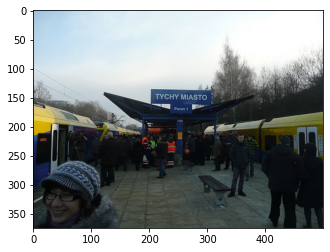

man in black shirt is standing on the street


In [ ]:
model.save('/content/drive/MyDrive/MotaHinhanh/model_weights/model_30.h5')

images = '/content/drive/MyDrive/MotaHinhanh/Flicker8k_Dataset/'

with open("/content/drive/MyDrive/MotaHinhanh/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

z=5
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))

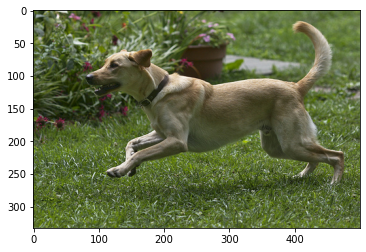

dog runs through the grass


In [ ]:
z=56
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))

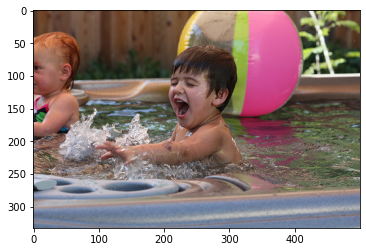

boy in pool pool


In [ ]:
z=273
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))

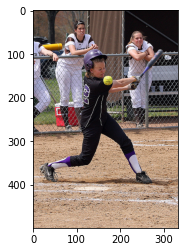

boy in baseball uniform is playing baseball


In [ ]:
z=95
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))

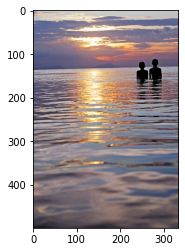

two people are standing on the beach


In [ ]:
z=666
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))

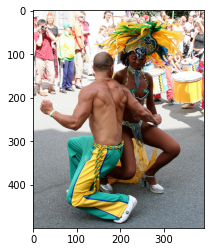

man in red shirt is standing in front of the water


In [ ]:
z=15
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))

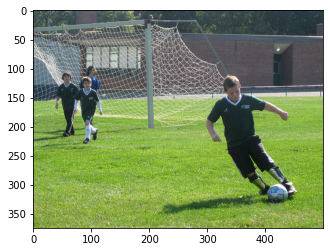

boy in red shirt and red shirt is running on the grass


In [ ]:
z=925
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))